In [13]:
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import timm

In [14]:
from PIL import Image

In [15]:
batch_size = 2048
num_workers = 8

model_name = 'vit_base_patch32_224'
pretrained = False
num_classes = 200

device_gpu = 'cuda:3'

label_smoothing = 0.1
learning_rate = 0.001
epochs = 30

model_path = 'test_model.pth'  # 모델 저장 경로

In [16]:
# # 데이터 증강을 위한 전처리
# transform_train = transforms.Compose([
#     transforms.RandomResizedCrop(224),  # 무작위 크기 및 비율로 자르기
#     transforms.RandomHorizontalFlip(),  # 50% 확률로 수평 뒤집기
#     transforms.RandomRotation(15),      # -15도에서 15도 사이로 무작위 회전
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # 색상 변경
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])

# transform_test = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])

# trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

# testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
# testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)


In [17]:
# import os
# from torch.utils.data import Dataset, DataLoader
# from torchvision.transforms.autoaugment import AutoAugmentPolicy

# # 데이터셋 경로 설정
# data_dir = './data/tiny-imagenet-200'  # Tiny ImageNet 데이터셋이 저장된 경로
# # WordNet ID와 클래스 이름을 매핑하는 사전을 생성합니다.
# id_to_class = {}
# with open(os.path.join(data_dir, 'wnids.txt'), 'r') as f:
#     for idx, line in enumerate(f):
#         wordnet_id = line.strip()
#         id_to_class[idx] = wordnet_id
        
# # Transforms 정의하기
# train_transform = transforms.Compose([
#     transforms.RandomResizedCrop(224, scale=(0.8,1), interpolation=transforms.InterpolationMode.LANCZOS),
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

# test_transform = transforms.Compose([
#     transforms.Resize((112, 112)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])


# # 클래스 이름 목록을 만듭니다.
# class_names = list(id_to_class.values())

# # 클래스 이름을 정수 인덱스로 매핑하는 사전 생성
# class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}

# # 사용자 정의 데이터셋 클래스
# class TinyImageNetDataset(Dataset):
#     def __init__(self, root_dir, transform=None, is_train=True):
#         """
#         Args:
#             root_dir (string): 데이터셋의 디렉토리 경로.
#             transform (callable, optional): 적용할 transform.
#             is_train (bool, optional): 학습 데이터셋인지 테스트 데이터셋인지 구분.
#         """
#         self.root_dir = root_dir
#         self.transform = transform
#         self.is_train = is_train
#         self.images = []  # 이미지 파일 경로를 저장할 리스트
#         self.labels = []  # 레이블을 저장할 리스트

#         # 이미지와 레이블을 로드하는 로직
#         if is_train:
#             for class_dir in os.listdir(os.path.join(root_dir, 'train')):
#                 class_dir_path = os.path.join(root_dir, 'train', class_dir, 'images')
#                 for img_file in os.listdir(class_dir_path):
#                     self.images.append(os.path.join(class_dir_path, img_file))
#                     self.labels.append(class_dir)
#         else:
#             with open(os.path.join(root_dir, 'val', 'val_annotations.txt'), 'r') as f:
#                 for line in f:
#                     parts = line.strip().split()
#                     img_file, wordnet_id = parts[0], parts[1]
#                     self.images.append(os.path.join(root_dir, 'val', 'images', img_file))
#                     class_name = id_to_class.get(wordnet_id, "")
#                     self.labels.append(class_name)

#     def __len__(self):
#         return len(self.images)

#     def __getitem__(self, idx):
#         img_name = self.images[idx]
#         image = Image.open(img_name).convert('RGB')

#         if self.transform:
#             image = self.transform(image)

#         class_name = self.labels[idx]
#         if class_name in class_to_idx:
#             label_idx = class_to_idx[class_name]  # 클래스 이름을 정수 인덱스로 변환
#         else:
#             print(f"Class name '{class_name}' not found in class_to_idx")
#             label_idx = -1
#         return image, label_idx
    
# # 데이터셋 인스턴스 생성
# trainset = TinyImageNetDataset(data_dir, transform=train_transform, is_train=True)
# testset = TinyImageNetDataset(data_dir, transform=test_transform, is_train=False)

# # DataLoader 설정
# trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=False)
# testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

In [18]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

img_size = 224
num_classes = 100

# 데이터셋 경로 설정
data_dir = './data/sports'  # Tiny ImageNet 데이터셋이 저장된 경로

# Transforms 정의하기
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(img_size, scale=(0.8,1), interpolation=transforms.InterpolationMode.LANCZOS),
    transforms.RandomHorizontalFlip(),
    # transforms.AutoAugment(AutoAugmentPolicy.IMAGENET),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.2)),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# dataset load
train_data = ImageFolder('./data/sports/train', transform=train_transform)
valid_data = ImageFolder('./data/sports/valid', transform=test_transform)
test_data = ImageFolder('./data/sports/test', transform=test_transform)

trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
validloader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)
testloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [19]:
len(trainloader), len(testloader)

(7, 1)

In [20]:
model = timm.create_model(model_name=model_name, 
                          pretrained=pretrained, 
                          num_classes=num_classes)

device = torch.device(device_gpu if torch.cuda.is_available() else "cpu")
model.to(device)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [21]:
from types import SimpleNamespace
from timm.optim.optim_factory import create_optimizer

args = SimpleNamespace()
args.weight_decay = 0
args.lr = 1e-3
args.opt = 'adam' #'lookahead_adam' to use `lookahead`
args.momentum = 0.9

optimizer = create_optimizer(args, model)

In [22]:
# criterion1 = nn.CrossEntropyLoss(label_smoothing=label_smoothing)
criterion2 = nn.CrossEntropyLoss(label_smoothing=0.0)
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.1)
# scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, max_lr=learning_rate*2, total_steps=epochs*len(trainloader))

In [23]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [24]:
from tqdm import tqdm
training_time = 0
# early_stopping = EarlyStopping(patience=30)
losses = []
lrs = []
best_loss = float('inf')

vit_save = False
model.to(device)

for epoch in range(epochs):
    model.train()
    start_time = time.time()
    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader), total=len(trainloader), desc=f"Epoch {epoch + 1}")
    for i, data in pbar:
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion2(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        running_loss += loss.item()
        lr = optimizer.param_groups[0]["lr"]
        lrs.append(lr)
    epoch_loss = running_loss / len(trainloader)
    losses.append(epoch_loss)
    
    # 모델 저장
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        vit_save = True
        torch.save(model.state_dict(), model_path)

    epoch_duration = time.time() - start_time
    training_time += epoch_duration
    text = f'\tLoss: {epoch_loss}, LR: {lr}, Duration: {epoch_duration:.2f} sec'
    
    if vit_save:
        text += f' - model saved!'
        print(text)
        vit_save = False
    # elif epoch % 5 == 4 :
    #     print(text)
    else : 
        print(text)

    # # Early Stopping 체크
    # early_stopping(loss)
    # if early_stopping.early_stop:
    #     print("Early stopping")
    #     break


Epoch 1: 100%|██████████| 7/7 [00:55<00:00,  7.94s/it]


	Loss: 4.69489860534668, LR: 0.001, Duration: 56.31 sec - model saved!


Epoch 2: 100%|██████████| 7/7 [00:55<00:00,  7.92s/it]


	Loss: 4.275183405194964, LR: 0.001, Duration: 56.16 sec - model saved!


Epoch 3: 100%|██████████| 7/7 [00:55<00:00,  7.96s/it]


	Loss: 4.110435485839844, LR: 0.001, Duration: 56.43 sec - model saved!


Epoch 4: 100%|██████████| 7/7 [00:56<00:00,  8.01s/it]


	Loss: 3.9872287000928606, LR: 0.001, Duration: 56.77 sec - model saved!


Epoch 5: 100%|██████████| 7/7 [00:55<00:00,  7.98s/it]


	Loss: 3.8956184727805003, LR: 0.001, Duration: 56.58 sec - model saved!


Epoch 6: 100%|██████████| 7/7 [00:57<00:00,  8.21s/it]


	Loss: 3.8219876970563615, LR: 0.001, Duration: 58.13 sec - model saved!


Epoch 7: 100%|██████████| 7/7 [00:58<00:00,  8.30s/it]


	Loss: 3.7280175345284596, LR: 0.001, Duration: 58.79 sec - model saved!


Epoch 8: 100%|██████████| 7/7 [00:55<00:00,  7.97s/it]


	Loss: 3.642583336148943, LR: 0.001, Duration: 56.46 sec - model saved!


Epoch 9: 100%|██████████| 7/7 [00:53<00:00,  7.68s/it]


	Loss: 3.5935776574271068, LR: 0.001, Duration: 54.47 sec - model saved!


Epoch 10: 100%|██████████| 7/7 [01:00<00:00,  8.61s/it]


	Loss: 3.4805946350097656, LR: 0.001, Duration: 61.00 sec - model saved!


Epoch 11: 100%|██████████| 7/7 [00:57<00:00,  8.19s/it]


	Loss: 3.4055077689034596, LR: 0.001, Duration: 58.06 sec - model saved!


Epoch 12: 100%|██████████| 7/7 [00:54<00:00,  7.77s/it]


	Loss: 3.33124532018389, LR: 0.001, Duration: 55.14 sec - model saved!


Epoch 13: 100%|██████████| 7/7 [00:57<00:00,  8.27s/it]


	Loss: 3.2587106227874756, LR: 0.001, Duration: 58.59 sec - model saved!


Epoch 14: 100%|██████████| 7/7 [00:57<00:00,  8.28s/it]


	Loss: 3.2613769599369595, LR: 0.001, Duration: 57.99 sec


Epoch 15: 100%|██████████| 7/7 [00:57<00:00,  8.22s/it]


	Loss: 3.1709467002323697, LR: 0.001, Duration: 58.14 sec - model saved!


Epoch 16: 100%|██████████| 7/7 [00:58<00:00,  8.32s/it]


	Loss: 3.0589236191340854, LR: 0.001, Duration: 59.03 sec - model saved!


Epoch 17: 100%|██████████| 7/7 [00:57<00:00,  8.28s/it]


	Loss: 2.989866631371634, LR: 0.001, Duration: 58.71 sec - model saved!


Epoch 18: 100%|██████████| 7/7 [00:57<00:00,  8.21s/it]


	Loss: 2.872553450720651, LR: 0.001, Duration: 58.14 sec - model saved!


Epoch 19: 100%|██████████| 7/7 [00:57<00:00,  8.18s/it]


	Loss: 2.785914421081543, LR: 0.001, Duration: 57.98 sec - model saved!


Epoch 20: 100%|██████████| 7/7 [00:57<00:00,  8.21s/it]


	Loss: 2.780359847205026, LR: 0.001, Duration: 58.15 sec - model saved!


Epoch 21: 100%|██████████| 7/7 [00:56<00:00,  8.13s/it]


	Loss: 2.7171405383518765, LR: 0.001, Duration: 57.68 sec - model saved!


Epoch 22: 100%|██████████| 7/7 [00:57<00:00,  8.23s/it]


	Loss: 2.5733107839311873, LR: 0.001, Duration: 58.31 sec - model saved!


Epoch 23: 100%|██████████| 7/7 [00:57<00:00,  8.29s/it]


	Loss: 2.4832159110477994, LR: 0.001, Duration: 58.73 sec - model saved!


Epoch 24: 100%|██████████| 7/7 [00:58<00:00,  8.31s/it]


	Loss: 2.405845505850656, LR: 0.001, Duration: 58.95 sec - model saved!


Epoch 25: 100%|██████████| 7/7 [01:03<00:00,  9.11s/it]


	Loss: 2.358110155378069, LR: 0.001, Duration: 64.46 sec - model saved!


Epoch 26: 100%|██████████| 7/7 [01:02<00:00,  8.96s/it]


	Loss: 2.3400332927703857, LR: 0.001, Duration: 63.47 sec - model saved!


Epoch 27: 100%|██████████| 7/7 [01:04<00:00,  9.28s/it]


	Loss: 2.2378454208374023, LR: 0.001, Duration: 65.54 sec - model saved!


Epoch 28: 100%|██████████| 7/7 [01:03<00:00,  9.11s/it]


	Loss: 2.1102987357548306, LR: 0.001, Duration: 64.45 sec - model saved!


Epoch 29: 100%|██████████| 7/7 [01:02<00:00,  8.98s/it]


	Loss: 2.0247394187109813, LR: 0.001, Duration: 63.54 sec - model saved!


Epoch 30: 100%|██████████| 7/7 [01:04<00:00,  9.16s/it]


	Loss: 1.9844332592827933, LR: 0.001, Duration: 64.81 sec - model saved!


Epoch 1: 100%|██████████| 7/7 [01:01<00:00,  8.80s/it]


Epoch 1, Loss: 1.9094892059053694, Val Loss: 2.5533063411712646, LR: 0.001, LS: 0.0, Duration: 63.95 sec - model saved!


Epoch 2: 100%|██████████| 7/7 [01:01<00:00,  8.83s/it]


Epoch 2, Loss: 1.8623239994049072, Val Loss: 2.6928441524505615, LR: 0.001, LS: 0.0034482758620689655, Duration: 63.15 sec


Epoch 3: 100%|██████████| 7/7 [00:58<00:00,  8.39s/it]


Epoch 3, Loss: 1.8364830357687814, Val Loss: 2.682056188583374, LR: 0.001, LS: 0.006896551724137931, Duration: 59.75 sec


Epoch 4: 100%|██████████| 7/7 [01:00<00:00,  8.68s/it]


Epoch 4, Loss: 1.77013555594853, Val Loss: 2.6081702709198, LR: 0.001, LS: 0.010344827586206896, Duration: 61.96 sec


Epoch 5: 100%|██████████| 7/7 [01:01<00:00,  8.75s/it]


Epoch 5, Loss: 1.6859998873301916, Val Loss: 2.537078380584717, LR: 0.001, LS: 0.013793103448275862, Duration: 62.85 sec - model saved!


Epoch 6: 100%|██████████| 7/7 [01:04<00:00,  9.25s/it]


Epoch 6, Loss: 1.6419294561658586, Val Loss: 2.524188995361328, LR: 0.001, LS: 0.01724137931034483, Duration: 66.38 sec - model saved!


Epoch 7: 100%|██████████| 7/7 [01:00<00:00,  8.64s/it]


Epoch 7, Loss: 1.6013142551694597, Val Loss: 2.556516170501709, LR: 0.001, LS: 0.020689655172413793, Duration: 61.70 sec


Epoch 8: 100%|██████████| 7/7 [00:58<00:00,  8.40s/it]


Epoch 8, Loss: 1.5978051934923445, Val Loss: 2.6014857292175293, LR: 0.001, LS: 0.024137931034482762, Duration: 59.87 sec


Epoch 9: 100%|██████████| 7/7 [01:02<00:00,  8.99s/it]


Epoch 9, Loss: 1.5579742533820016, Val Loss: 2.577888011932373, LR: 0.001, LS: 0.027586206896551724, Duration: 63.91 sec


Epoch 10: 100%|██████████| 7/7 [01:00<00:00,  8.60s/it]


Epoch 10, Loss: 1.4649484498160226, Val Loss: 2.6531739234924316, LR: 0.001, LS: 0.031034482758620693, Duration: 60.91 sec


Epoch 11: 100%|██████████| 7/7 [01:02<00:00,  8.96s/it]


Epoch 11, Loss: 1.4417927435466222, Val Loss: 2.696108818054199, LR: 0.001, LS: 0.03448275862068966, Duration: 64.20 sec
Early stopping


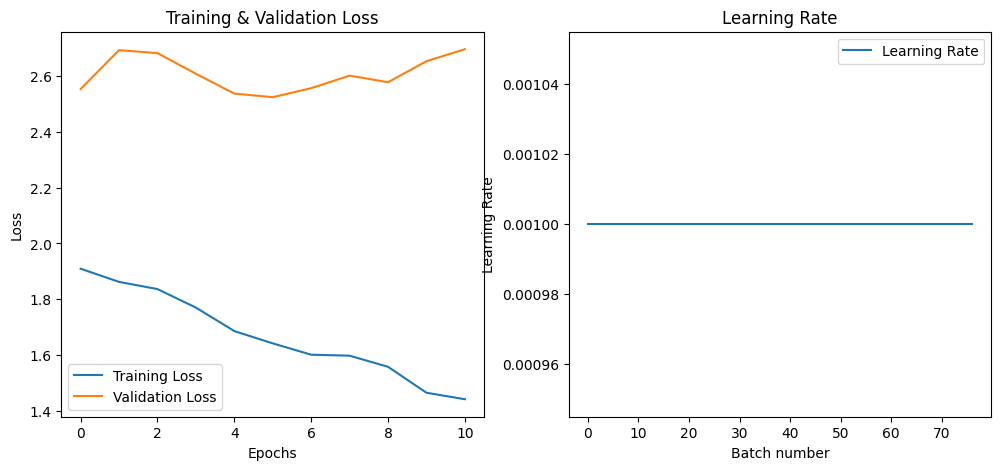

In [25]:
from tqdm import tqdm

training_time = 0
early_stopping = EarlyStopping(patience=5)
losses = []
val_losses = []
lrs = []
best_val_loss = float('inf')

model_save = False

for epoch in range(epochs):
    model.train()
    start_time = time.time()
    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader), total=len(trainloader), desc=f"Epoch {epoch + 1}")
    smoothing_ratio = label_smoothing * (epoch/(epochs-1))
    criterion1 = nn.CrossEntropyLoss(label_smoothing=smoothing_ratio) # 처음에는 ls없다가 서서히 증가시켜보기
    for i, data in pbar:
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion1(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        running_loss += loss.item()
        lr = optimizer.param_groups[0]["lr"]
        lrs.append(lr)
    epoch_loss = running_loss / len(trainloader)
    losses.append(epoch_loss)

    # 검증 손실 계산
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion2(outputs, labels)
            val_loss += loss.item()
    val_loss /= len(testloader)
    val_losses.append(val_loss)

    # 모델 저장
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        model_save = True
        torch.save(model.state_dict(), model_path)

    epoch_duration = time.time() - start_time
    training_time += epoch_duration
    if model_save:
        print(f'Epoch {epoch + 1}, Loss: {epoch_loss}, Val Loss: {val_loss}, LR: {lr}, LS: {smoothing_ratio}, Duration: {epoch_duration:.2f} sec - model saved!')
        model_save = False
    else :
        print(f'Epoch {epoch + 1}, Loss: {epoch_loss}, Val Loss: {val_loss}, LR: {lr}, LS: {smoothing_ratio}, Duration: {epoch_duration:.2f} sec')

    # Early Stopping 체크
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping")
        break

# 학습 및 검증 손실 시각화
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(lrs, label='Learning Rate')
plt.title('Learning Rate')
plt.xlabel('Batch number')
plt.ylabel('Learning Rate')
plt.legend()
plt.show()


In [26]:
model_path, device_gpu

('test_model.pth', 'cuda:3')

In [27]:
vit = torch.load(model_path, map_location=device_gpu)

In [28]:
vit.keys()

odict_keys(['cls_token', 'pos_embed', 'patch_embed.proj.weight', 'patch_embed.proj.bias', 'blocks.0.norm1.weight', 'blocks.0.norm1.bias', 'blocks.0.attn.qkv.weight', 'blocks.0.attn.qkv.bias', 'blocks.0.attn.proj.weight', 'blocks.0.attn.proj.bias', 'blocks.0.norm2.weight', 'blocks.0.norm2.bias', 'blocks.0.mlp.fc1.weight', 'blocks.0.mlp.fc1.bias', 'blocks.0.mlp.fc2.weight', 'blocks.0.mlp.fc2.bias', 'blocks.1.norm1.weight', 'blocks.1.norm1.bias', 'blocks.1.attn.qkv.weight', 'blocks.1.attn.qkv.bias', 'blocks.1.attn.proj.weight', 'blocks.1.attn.proj.bias', 'blocks.1.norm2.weight', 'blocks.1.norm2.bias', 'blocks.1.mlp.fc1.weight', 'blocks.1.mlp.fc1.bias', 'blocks.1.mlp.fc2.weight', 'blocks.1.mlp.fc2.bias', 'blocks.2.norm1.weight', 'blocks.2.norm1.bias', 'blocks.2.attn.qkv.weight', 'blocks.2.attn.qkv.bias', 'blocks.2.attn.proj.weight', 'blocks.2.attn.proj.bias', 'blocks.2.norm2.weight', 'blocks.2.norm2.bias', 'blocks.2.mlp.fc1.weight', 'blocks.2.mlp.fc1.bias', 'blocks.2.mlp.fc2.weight', 'bloc

In [30]:
from sklearn.metrics import confusion_matrix
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# 예측 수행 및 레이블 저장
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = vit(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 혼동 행렬 생성
cm = confusion_matrix(all_labels, all_preds)

# 예측과 실제 레이블
y_true = all_labels  # 실제 레이블
y_pred = all_preds  # 모델에 의해 예측된 레이블

# 전체 데이터셋에 대한 정확도
accuracy = accuracy_score(y_true, y_pred)

# 평균 정밀도, 리콜, F1-Score ('weighted')
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

# 판다스 데이터프레임으로 결과 정리
performance_metrics = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Value': [accuracy, precision, recall, f1_score]
})

# 데이터프레임 출력
print(performance_metrics)

TypeError: 'collections.OrderedDict' object is not callable

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# Hook 함수 정의 및 등록
attention_maps = []
def get_attention_map(module, input, output):
    global attention_maps
    attention_maps.append(output[1].detach())
hook = vit.transformer_encoders[0].attn.register_forward_hook(get_attention_map)

# 모델을 통한 예측 및 Attention Map 추출
original_images, labels = next(iter(testloader))
outputs = vit(original_images.to(device))
_, predicted = torch.max(outputs, 1)
hook.remove()

# CIFAR-10 클래스 레이블
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Attention Map 가공 및 시각화 개선 함수
def show_attention_on_image(img, attention_map, label, pred, threshold=0.0):
    # 이미지 크기에 맞게 Attention Map 조정
    attention_map = attention_map.cpu().numpy()
    attention_map = attention_map - np.min(attention_map)
    attention_map = attention_map / np.max(attention_map)

    # 임계값 이하의 Attention 값 제거
    # attention_map[attention_map < threshold] = 0

    # 원본 이미지 크기로 Attention Map 업샘플링
    attention_map_resized = np.resize(attention_map, (img.shape[1], img.shape[2]))

    # 원본 이미지와 Attention Map 겹쳐서 표시
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(img.permute(1, 2, 0))
    axs[0].axis('off')
    axs[0].set_title(f'Original Image\nTrue Label: {label}')

    axs[1].imshow(img.permute(1, 2, 0))
    axs[1].imshow(attention_map_resized, cmap='jet', alpha=0.6)  # 투명도 조절
    axs[1].axis('off')
    axs[1].set_title(f'Image with Attention Map\nPredicted: {pred}')

    plt.show()

# 각 이미지에 대해 시각화 수행
for i in range(4):
    show_attention_on_image(original_images[i], attention_maps[0][i], classes[labels[i]], classes[predicted[i]])


AttributeError: 'collections.OrderedDict' object has no attribute 'transformer_encoders'